# EDA

Flight Delay Prediction Challenge.
Predict airline delays for Tunisian aviation company, Tunisair.

Hypotheses:
1) Flights departing from certain airports experience longer delays than others.
2) Morning flights have fewer delays than evening flights.
3) Certain aircraft types have higher delays due to mainteance or operational issues.
4) Delays are higher during peak travel season?


## Load packages

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedStratifiedKFold

import xgboost as xgb
import catboost as cb
from catboost import CatBoostRegressor
from sklearn.inspection import partial_dependence, PartialDependenceDisplay
from sklearn.inspection import permutation_importance
from sklearn.dummy import DummyRegressor
from scipy.stats import uniform, randint

## Load and explore data

Column definitions

DATOP - Date of flight <br>
FLTID - Flight number <br>
DEPSTN - Departure point <br>
ARRSTN - Arrival point <br>
STD - Scheduled Time departure <br>
STA - Scheduled Time arrival <br>
STATUS - Flight status <br>
AC - Aircraft Code <br>
Target - Delay in minutes <br>

In [3]:
df = pd.read_csv("data/RawData.csv")
df

,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,target
0,train_id_0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12.55.00,ATA,TU 32AIMN,260.0
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16.55.00,ATA,TU 31BIMO,20.0
2,train_id_2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06.45.00,ATA,TU 32AIMN,0.0
3,train_id_3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17.00.00,ATA,TU 736IOK,0.0
4,train_id_4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15.50.00,ATA,TU 320IMU,22.0
...,...,...,...,...,...,...,...,...,...,...
107828,train_id_107828,2018-07-05,WKL 0000,TUN,TUN,2018-07-05 23:00:00,2018-07-06 02.00.00,SCH,TU 32AIML,0.0
107829,train_id_107829,2018-01-13,UG 0003,DJE,TUN,2018-01-13 08:00:00,2018-01-13 09.00.00,SCH,UG AT7AT7,0.0
107830,train_id_107830,2018-11-07,SGT 0000,TUN,TUN,2018-11-07 05:00:00,2018-11-07 12.50.00,SCH,TU 736IOK,0.0
107831,train_id_107831,2018-01-23,UG 0010,TUN,DJE,2018-01-23 18:00:00,2018-01-23 18.45.00,ATA,TU CR9ISA,0.0


In [4]:
print("shape", df.shape)
print(df.info())

shape (107833, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107833 entries, 0 to 107832
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      107833 non-null  object 
 1   DATOP   107833 non-null  object 
 2   FLTID   107833 non-null  object 
 3   DEPSTN  107833 non-null  object 
 4   ARRSTN  107833 non-null  object 
 5   STD     107833 non-null  object 
 6   STA     107833 non-null  object 
 7   STATUS  107833 non-null  object 
 8   AC      107833 non-null  object 
 9   target  107833 non-null  float64
dtypes: float64(1), object(9)
memory usage: 8.2+ MB
None


In [5]:
# Convert columns
df["DATOP"] = pd.to_datetime(df["DATOP"])
df["STD"] = pd.to_datetime(df["STD"])
df["STA"] = pd.to_datetime(df["STA"], format='%Y-%m-%d %H.%M.%S')

# Add columns
df["FlightYear"] = df["DATOP"].dt.year
df["Departure_Month"] = df["STD"].dt.month
df["Departure_Day"] = df["STD"].dt.day
df["Departure_Weekday"] = df["STD"].dt.weekday

df["Departure_Hour"] = df["STD"].dt.hour
df["Departure_Minute"] = df["STD"].dt.minute

# Classifying into morning (4-12), afternoon (12-17), evening (18-23) and night (0-4)
df['Departure_Time_Of_Day'] = pd.cut(df['Departure_Hour'], bins=[0, 6, 12, 18, 24], labels=['night', 'morning', 'afternoon', 'evening'], right=False)

# Calculating flight duration
df['Flight_Duration'] = (((df['STA'] - df['STD']).dt.total_seconds()) / 60).astype(int)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107833 entries, 0 to 107832
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   ID                     107833 non-null  object        
 1   DATOP                  107833 non-null  datetime64[ns]
 2   FLTID                  107833 non-null  object        
 3   DEPSTN                 107833 non-null  object        
 4   ARRSTN                 107833 non-null  object        
 5   STD                    107833 non-null  datetime64[ns]
 6   STA                    107833 non-null  datetime64[ns]
 7   STATUS                 107833 non-null  object        
 8   AC                     107833 non-null  object        
 9   target                 107833 non-null  float64       
 10  FlightYear             107833 non-null  int32         
 11  Departure_Month        107833 non-null  int32         
 12  Departure_Day          107833 non-null  int3

In [6]:
# Drop rows where STATUS is "RTR" (returned to origin), "DEL" (cancelled) or "SCH"(still in the air), because aircraft never arrived at destination
df = df[~df["STATUS"].isin(["RTR", "DEL", "SCH"])]
df["STATUS"].unique()

# Drop column "STATUS" because it is not informative
df =df.drop(columns=["STATUS"])

In [7]:
# Check missing values --> no missing values
print(df.isnull().sum())

ID                       0
DATOP                    0
FLTID                    0
DEPSTN                   0
ARRSTN                   0
STD                      0
STA                      0
AC                       0
target                   0
FlightYear               0
Departure_Month          0
Departure_Day            0
Departure_Weekday        0
Departure_Hour           0
Departure_Minute         0
Departure_Time_Of_Day    0
Flight_Duration          0
dtype: int64


# Train-test split

In [7]:
# Train Test Split
X = df.drop(columns=["target"])
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Feature Engineering

In [8]:
# Not using OneHotEncoder 

X_train = X_train.drop(columns=["ID", "DATOP", "FLTID", "STD", "STA", "AC","Departure_Day","Departure_Hour","Departure_Minute"])
X_test = X_test.drop(columns=["ID", "DATOP", "FLTID", "STD", "STA", "AC","Departure_Day","Departure_Hour","Departure_Minute"])


In [17]:
cat_features = ['DEPSTN', 'ARRSTN', 'Departure_Month', 'Departure_Weekday', 'Departure_Time_Of_Day']  # List of categorical feature names

# Initialize the CatBoostRegressor model
catboost_model = CatBoostRegressor(iterations=1000, learning_rate=0.1, cat_features=cat_features, depth=6, verbose=0)

# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'iterations': randint(500, 1500),  # Randomize iterations between 500 and 1500
    'learning_rate': uniform(0.01, 0.2),  # Randomize learning rate between 0.01 and 0.2
    'depth': randint(4, 10),  # Randomize depth between 4 and 10
    'l2_leaf_reg': uniform(1, 10),  # Randomize L2 regularization parameter between 1 and 10
    'border_count': randint(32, 255),  # Randomize border_count between 32 and 255
}

# Set up RandomizedSearchCV with cross-validation
random_search = RandomizedSearchCV(
    estimator=catboost_model,
    param_distributions=param_dist,
    n_iter=10,  # Number of iterations (random combinations of hyperparameters to try)
    scoring='neg_mean_squared_error',  # Use negative MSE as the scoring metric
    cv=3,  # 3-fold cross-validation
    verbose=2,  # Show progress
    random_state=42
)

# Fit the RandomizedSearchCV
random_search.fit(X_train, y_train)

# Print the best parameters from the random search
print("Best Hyperparameters: ", random_search.best_params_)

# Make predictions using the best model found from RandomizedSearchCV
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the model performance using MSE
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error on Test Set: {mse}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END border_count=134, depth=7, iterations=1360, l2_leaf_reg=2.8343478986616377, learning_rate=0.16593820005455387; total time= 1.8min
[CV] END border_count=134, depth=7, iterations=1360, l2_leaf_reg=2.8343478986616377, learning_rate=0.16593820005455387; total time= 1.9min
[CV] END border_count=134, depth=7, iterations=1360, l2_leaf_reg=2.8343478986616377, learning_rate=0.16593820005455387; total time= 1.8min
[CV] END border_count=52, depth=5, iterations=966, l2_leaf_reg=1.9997491581800289, learning_rate=0.10184977839317343; total time=  51.5s
[CV] END border_count=52, depth=5, iterations=966, l2_leaf_reg=1.9997491581800289, learning_rate=0.10184977839317343; total time=  50.4s
[CV] END border_count=52, depth=5, iterations=966, l2_leaf_reg=1.9997491581800289, learning_rate=0.10184977839317343; total time=  47.6s
[CV] END border_count=148, depth=7, iterations=1371, l2_leaf_reg=8.080725777960454, learning_rate=0.01411689885

In [20]:
#Model evaluation
y_train_cb_pred = best_model.predict(X_train)
y_test_cb_pred = best_model.predict(X_test)
model_evaluation(y_train, y_train_cb_pred, y_test, y_test_cb_pred) 

Training evaluation metrics: 
Mean absolute error (MAE):  54.93304875601105
Mean square error (MSE):  13756.35392313414
Root mean square error (RMSE):  117.28748408561819
R2 coefficient of determination:  0.10427337463402386

---------------
Test Evaluation Metrics
Mean absolute error (MAE):  55.26061016753705
Mean square error (MSE):  13354.744923409786
Root mean square error (RMSE): 115.5627315504864
R2 coefficient of determination:  0.08818280546546642


# Functions to evaluate model

In [19]:
def model_evaluation(train, train_pred, test, test_pred):

    print('Training evaluation metrics: ')
    print('Mean absolute error (MAE): ', mean_absolute_error(train, train_pred))
    print('Mean square error (MSE): ', mean_squared_error(train, train_pred))
    print('Root mean square error (RMSE): ', mean_squared_error(train, train_pred) **0.5)
    print('R2 coefficient of determination: ', r2_score(train, train_pred))
    print('')
    print('---'*5)
    print('Test Evaluation Metrics')
    print('Mean absolute error (MAE): ', mean_absolute_error(test, test_pred))
    print('Mean square error (MSE): ', mean_squared_error(test, test_pred))
    print('Root mean square error (RMSE):', mean_squared_error(test, test_pred) **0.5)
    print('R2 coefficient of determination: ', r2_score(test, test_pred))

# Implement models

# Visualization of the results
Partial dependence plots? <br>
Permutation feature importance?

In [21]:
def error_analysis_train(y_train, y_pred_train):
    """Generated true vs. predicted values and residual scatter plot for models

    Args:
        y_test (array): true values for y_test
        y_pred_test (array): predicted values of model for y_test
    """     
    # Calculate residuals
    residuals_train = y_train - y_pred_train
    # Standardize residuals
    residuals_stand_train = (residuals_train - residuals_train.mean()) / residuals_train.std()
    
    # Plot real vs. predicted values 
    fig, ax = plt.subplots(1,3, figsize=(15, 5))
    plt.subplots_adjust(right=1)
    plt.suptitle('Train data: Error Analysis')

    # Train data
    min_val_train = min(y_train.min(), y_pred_train.min())
    max_val_train  = max(y_train.max(), y_pred_train.max())
    
    ax[0].scatter(y_pred_train, y_train, color="#FF5A36", alpha=0.7)
    ax[0].plot([min_val_train , max_val_train], [min_val_train, max_val_train], color="#193251")
    ax[0].set_title("True vs. predicted values", fontsize=16)
    ax[0].set_xlabel("predicted values")
    ax[0].set_ylabel("true values")
    ax[0].set_xlim((y_pred_train.min()-10), (y_pred_train.max()+10))
    ax[0].set_ylim((y_train.min()-40), (y_train.max()+40))
    
    ax[1].scatter(y_pred_train, residuals_train, color="#FF5A36", alpha=0.7)
    ax[1].plot([min_val_train, max_val_train], [0,0], color="#193251")
    ax[1].set_title("Residual Scatter Plot", fontsize=16)
    ax[1].set_xlabel("predicted values")
    ax[1].set_ylabel("residuals")
    ax[1].set_xlim((y_pred_train.min()-10), (y_pred_train.max()+10))
    ax[1].set_ylim((residuals_train.min()-10), (residuals_train.max()+10));

    ax[2].scatter(y_pred_train, residuals_stand_train, color="#FF5A36", alpha=0.7)
    ax[2].plot([min_val_train , max_val_train], [0,0], color="#193251")
    ax[2].set_title("Standardized Residual Scatter Plot", fontsize=16)
    ax[2].set_xlabel("predicted values")
    ax[2].set_ylabel("standardized residuals")
    ax[2].set_xlim((y_pred_train.min()-10), (y_pred_train.max()+10))
    ax[2].set_ylim((residuals_stand_train.min()-10), (residuals_stand_train.max()+10));


In [22]:
def error_analysis_test(y_test, y_pred_test):
    """Generated true vs. predicted values and residual scatter plot for models

    Args:
        y_test (array): true values for y_test
        y_pred_test (array): predicted values of model for y_test
    """     
    # Calculate residuals
    residuals = y_test - y_pred_test
    # Standardize residuals
    residuals_stand = (residuals - residuals.mean()) / residuals.std()
    
    # Plot real vs. predicted values 
    fig, ax = plt.subplots(1,3, figsize=(15, 5))
    plt.subplots_adjust(right=1)
    plt.suptitle('Test data: Error Analysis')

    # Test data
    min_val = min(y_test.min(), y_pred_test.min())
    max_val = max(y_test.max(), y_pred_test.max())
    
    ax[0].scatter(y_pred_test, y_test, color="#FF5A36", alpha=0.7)
    ax[0].plot([min_val, max_val], [min_val, max_val], color="#193251")
    ax[0].set_title("True vs. predicted values", fontsize=16)
    ax[0].set_xlabel("predicted values")
    ax[0].set_ylabel("true values")
    ax[0].set_xlim((y_pred_test.min()-10), (y_pred_test.max()+10))
    ax[0].set_ylim((y_test.min()-40), (y_test.max()+40))
    
    ax[1].scatter(y_pred_test, residuals, color="#FF5A36", alpha=0.7)
    ax[1].plot([min_val, max_val], [0,0], color="#193251")
    ax[1].set_title("Residual Scatter Plot", fontsize=16)
    ax[1].set_xlabel("predicted values")
    ax[1].set_ylabel("residuals")
    ax[1].set_xlim((y_pred_test.min()-10), (y_pred_test.max()+10))
    ax[1].set_ylim((residuals.min()-10), (residuals.max()+10));

    ax[2].scatter(y_pred_test, residuals_stand, color="#FF5A36", alpha=0.7)
    ax[2].plot([min_val, max_val], [0,0], color="#193251")
    ax[2].set_title("Standardized Residual Scatter Plot", fontsize=16)
    ax[2].set_xlabel("predicted values")
    ax[2].set_ylabel("standardized residuals")
    ax[2].set_xlim((y_pred_test.min()-10), (y_pred_test.max()+10))
    ax[2].set_ylim((residuals_stand.min()-10), (residuals_stand.max()+10));

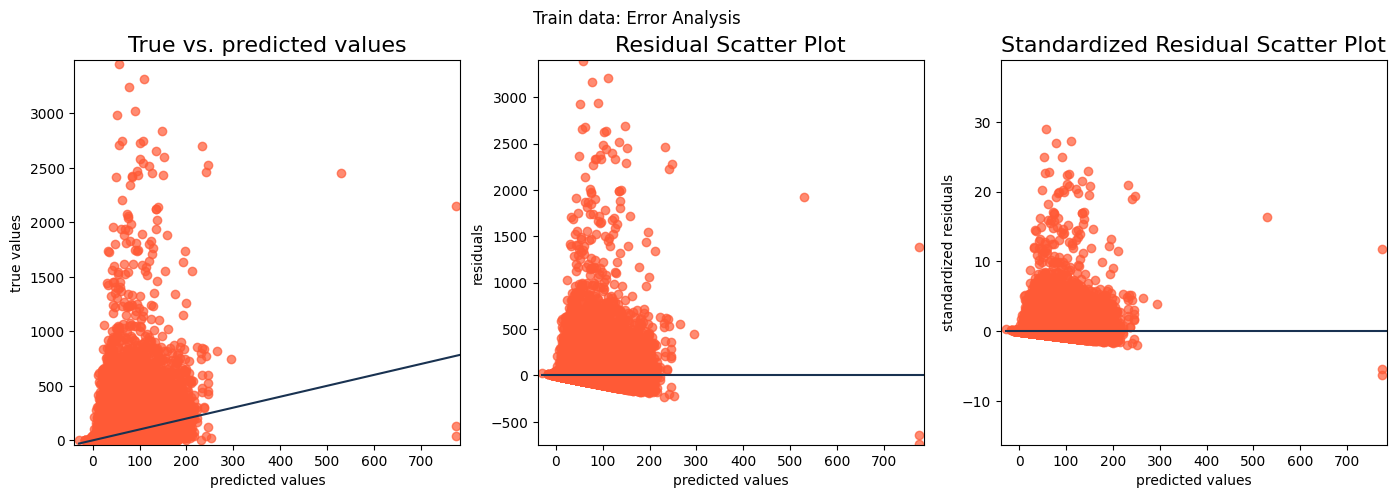

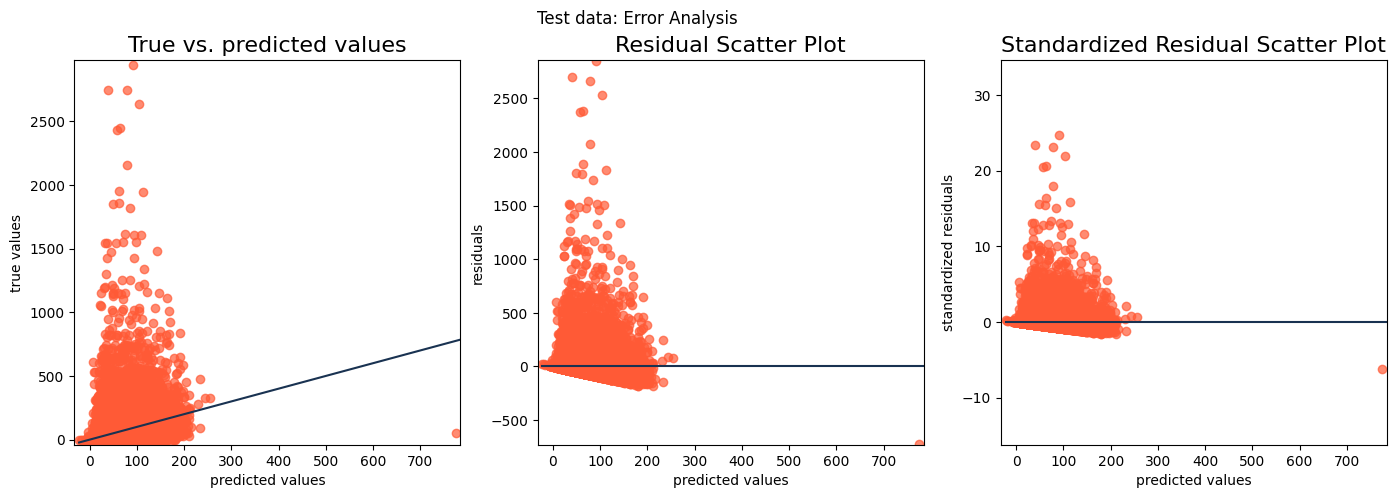

In [23]:
error_analysis_train(y_train, y_train_cb_pred) 
error_analysis_test(y_test, y_test_cb_pred)

TypeError: can't multiply sequence by non-int of type 'float'

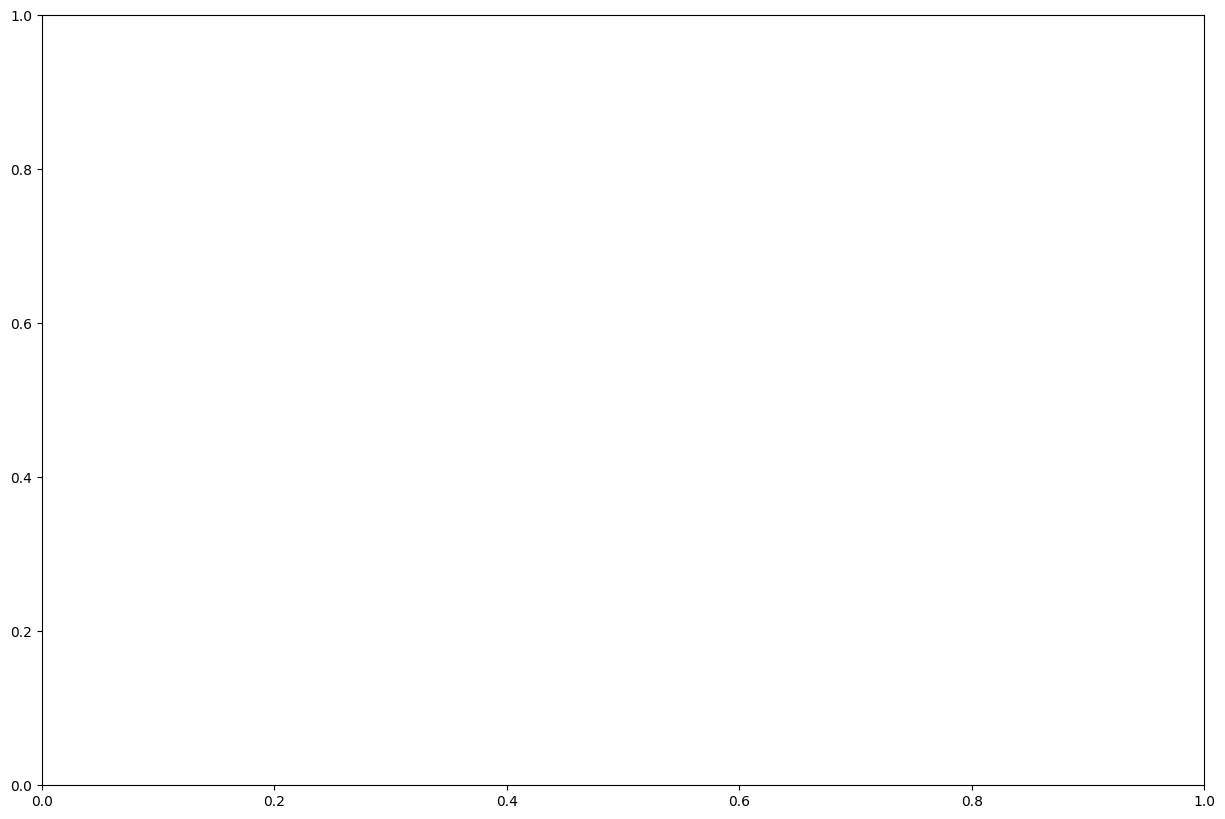

In [25]:
# Partial dependence plots
## Information: https://www.blog.trainindata.com/partial-dependence-plots-with-python/
### These plots allow us to visualize the relationship between a specific feature and the model’s predictions while holding all other features constant.
### In a partial dependence plot, we can see how the value of the model’s output changes at different values of the predictor. Hence, we can understand how important the feature is, and also, whether the relationship is linear, monotonic, or something else, and the direction of influence of the feature on the prediction.

features = [0, 1, 2, 3, 4] # Features we want to plot
fig, ax = plt.subplots(figsize=(15, 10))
display = PartialDependenceDisplay.from_estimator(best_model, X_train, features=features, kind='average', subsample=50, ax=ax)
ax.set_title('Partial Dependence Plot')
plt.show()

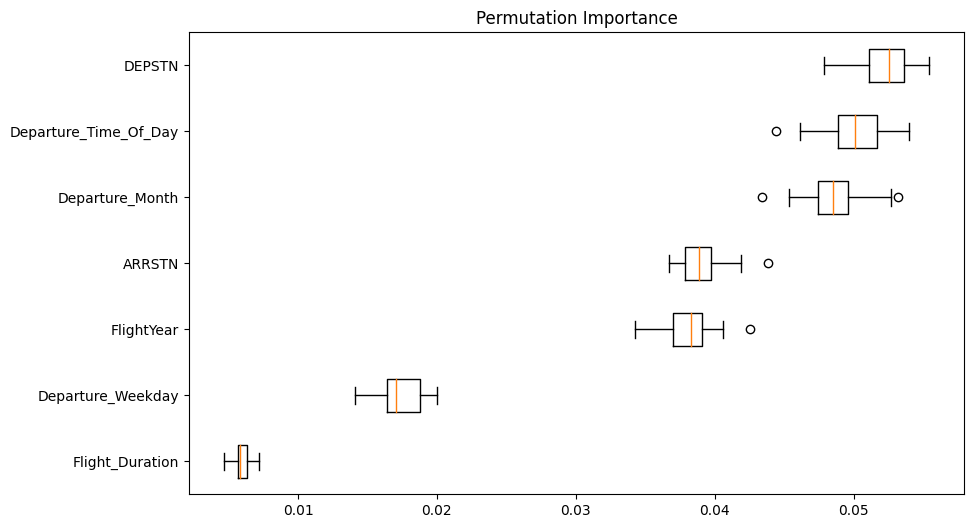

In [26]:
# Permutation feature importance
## Scoring method depends on the type of model (e.g. R^2 for regression models)
## Information: https://christophm.github.io/interpretable-ml-book/feature-importance.html
### We measure the importance of a feature by calculating the increase in the model’s prediction error after permuting the feature. A feature is “important” if shuffling its values increases the model error, because in this case the model relied on the feature for the prediction. A feature is “unimportant” if shuffling its values leaves the model error unchanged, because in this case the model ignored the feature for the prediction. 


perm_importance = permutation_importance(best_model, X_test, y_test, n_repeats=30, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort() #argsort sorts an array in ascending order and returns the indices of the sorted elements

plt.figure(figsize=(10, 6))
plt.boxplot(perm_importance.importances[sorted_idx].T, vert=False, labels=X_train.columns[sorted_idx])
plt.title("Permutation Importance")
plt.show()

